# Healthcare Provider Fraud Detection: Machine Learning Modeling

## Theoretical Foundation

### 1. Fraud Detection as a Classification Problem

Healthcare fraud detection is fundamentally a **binary classification problem** where we predict whether a provider is fraudulent (`1`) or legitimate (`0`). This presents unique challenges that distinguish it from standard classification tasks:

#### 1.1 Problem Characteristics
- **Severe Class Imbalance**: ~10% fraud rate creates significant bias toward majority class
- **High-Stakes Decisions**: False positives damage provider reputation; false negatives allow fraud to continue
- **Interpretability Requirements**: Regulators need explainable predictions for investigations
- **Evolving Fraud Patterns**: Fraudsters adapt, requiring robust and generalizable models

#### 1.2 Business Context
- **Cost of Investigation**: Limited resources require prioritizing high-confidence cases
- **Regulatory Compliance**: Models must align with healthcare regulations and audit requirements
- **Temporal Dynamics**: Fraud patterns evolve, necessitating regular model updates

### 2. Class Imbalance Handling Strategies

#### 2.1 Class Weighting (Chosen Approach)
**Theory**: Assigns higher penalties to misclassifying minority class samples during training.

**Mathematical Foundation**:
```
Class Weight = n_samples / (n_classes × n_samples_class)
```

**Advantages**:
- Preserves original data distribution
- Computationally efficient
- No synthetic data generation risks
- Works well with ensemble methods

**Limitations**:
- May increase false positive rate
- Requires careful threshold tuning

#### 2.2 Alternative Approaches (Considered but not implemented)
- **SMOTE**: Risk of generating unrealistic synthetic fraud patterns
- **Undersampling**: Loss of valuable information from majority class
- **Cost-Sensitive Learning**: Requires domain-specific cost matrices

### 3. Algorithm Selection Framework

#### 3.1 Evaluation Criteria
1. **Performance on Imbalanced Data**: Emphasis on F1-score and PR-AUC
2. **Interpretability**: Essential for regulatory compliance
3. **Robustness**: Stability across different data subsets
4. **Computational Efficiency**: Scalability to large datasets

#### 3.2 Selected Algorithms

**Logistic Regression**
- **Theory**: Linear decision boundary with probabilistic output
- **Advantages**: Highly interpretable, fast training, good baseline
- **Use Case**: Benchmark model and regulatory explanations

**Random Forest**
- **Theory**: Ensemble of decision trees with voting mechanism
- **Advantages**: Handles mixed data types, built-in feature importance, robust to outliers
- **Use Case**: Primary candidate for production deployment

**Decision Tree**
- **Theory**: Hierarchical splitting rules for classification
- **Advantages**: Maximum interpretability, handles non-linear patterns
- **Use Case**: Explanation model for specific cases

**Support Vector Machine (SVM)**
- **Theory**: Maximum margin classification with kernel trick
- **Advantages**: Effective in high-dimensional spaces, memory efficient
- **Use Case**: Complex pattern detection with RBF kernel

**XGBoost (Optional)**
- **Theory**: Gradient boosting with advanced regularization
- **Advantages**: State-of-the-art performance, built-in class weighting
- **Use Case**: Performance benchmark if computational resources allow

### 4. Evaluation Methodology

#### 4.1 Metrics Hierarchy
1. **Primary**: F1-Score (harmonic mean of precision/recall)
2. **Secondary**: PR-AUC (area under precision-recall curve)
3. **Supplementary**: ROC-AUC, Precision, Recall

#### 4.2 Why F1-Score Priority?
- Balances precision (false positive control) and recall (fraud detection)
- More meaningful than accuracy for imbalanced datasets
- Aligns with business objectives of effective fraud detection

#### 4.3 Cross-Validation Strategy
- **Stratified K-Fold**: Preserves class distribution across folds
- **K=5**: Balance between bias-variance trade-off and computational cost

### 5. Model Interpretability Requirements

#### 5.1 Regulatory Compliance
- Feature importance rankings
- Decision path explanations
- Confidence score interpretation

#### 5.2 Business Stakeholder Needs
- Clear feature contribution analysis
- Fraud pattern identification
- Risk scoring methodology

---

## 1. Setup and Data Loading

In [23]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [24]:
# Load the prepared dataset from feature engineering notebook
try:
    # Load the final dataset created in the previous notebook
    final_dataset = pd.read_csv('../data/provider_level.csv', index_col='Provider')
    
    print(f"✅ Dataset loaded successfully!")
    print(f"Dataset shape: {final_dataset.shape}")
    
    # Prepare features and target
    X = final_dataset.drop(['PotentialFraud', 'PotentialFraud_numeric'], axis=1)
    y = final_dataset['PotentialFraud_numeric']
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution:")
    print(f"  Non-fraud: {(y == 0).sum()} ({(y == 0).mean():.1%})")
    print(f"  Fraud: {(y == 1).sum()} ({(y == 1).mean():.1%})")
    
except FileNotFoundError:
    print("❌ Dataset not found. Please run the data exploration and feature engineering notebook first.")
    print("Expected file: ../data/provider_level.csv")

✅ Dataset loaded successfully!
Dataset shape: (5410, 35)
Features shape: (5410, 33)
Target distribution:
  Non-fraud: 4904 (90.6%)
  Fraud: 506 (9.4%)


## 2. Machine Learning Setup

In [25]:
# Import ML libraries
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_curve, auc, precision_score, recall_score, f1_score, 
    accuracy_score, roc_auc_score, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

try:
    import xgboost as xgb
    print("✅ XGBoost available")
except ImportError:
    print("⚠️ XGBoost not available, skipping XGBoost models")
    xgb = None

print("ML libraries loaded successfully!")

✅ XGBoost available
ML libraries loaded successfully!


In [26]:
# Data preparation for modeling
print("=== Data Preparation for Modeling ===")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights and scale_pos_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class weights: {class_weight_dict}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✅ Data preparation complete!")

=== Data Preparation for Modeling ===
Training set: (4328, 33), Test set: (1082, 33)
Class weights: {np.int64(0): np.float64(0.5516186591893959), np.int64(1): np.float64(5.3432098765432094)}
Scale pos weight: 9.69
✅ Data preparation complete!


## 3. Model Definition and Training

In [27]:
# Model evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba):
    """Comprehensive model evaluation"""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='binary'),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'F1': f1_score(y_true, y_pred, average='binary'),
        'ROC_AUC': roc_auc_score(y_true, y_pred_proba),
        'PR_AUC': average_precision_score(y_true, y_pred_proba)
    }

# Define models with class weighting
models = {
    'Logistic_Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ]),
    'Random_Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100))
    ]),
    'Decision_Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10))
    ]),
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', SVC(class_weight='balanced', random_state=42, probability=True))
    ])
}

if xgb is not None:
    models['XGBoost'] = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'))
    ])

print(f"✅ {len(models)} models defined: {list(models.keys())}")

✅ 5 models defined: ['Logistic_Regression', 'Random_Forest', 'Decision_Tree', 'SVM', 'XGBoost']


In [28]:
# Train and evaluate all models
print("=== Model Training and Evaluation ===")

results = []
trained_models = {}

for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_test = pipeline.predict(X_test)
        y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]
        
        # Evaluate
        metrics = evaluate_model(y_test, y_pred_test, y_pred_proba_test)
        metrics['Model'] = name
        results.append(metrics)
        
        # Store trained model
        trained_models[name] = pipeline
        
        print(f"  F1: {metrics['F1']:.4f}, PR-AUC: {metrics['PR_AUC']:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {e}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(results_df.round(4))

=== Model Training and Evaluation ===

Training Logistic_Regression...
  F1: 0.6298, PR-AUC: 0.7872

Training Random_Forest...
  F1: 0.7011, PR-AUC: 0.7847

Training Decision_Tree...
  F1: 0.6154, PR-AUC: 0.5187

Training SVM...
  F1: 0.7011, PR-AUC: 0.7847

Training Decision_Tree...
  F1: 0.6154, PR-AUC: 0.5187

Training SVM...
  F1: 0.6186, PR-AUC: 0.5786

Training XGBoost...
  F1: 0.7129, PR-AUC: 0.7841

=== Model Comparison Results ===
   Accuracy  Precision  Recall      F1  ROC_AUC  PR_AUC                Model
0    0.9011     0.4840  0.9010  0.6298   0.9697  0.7872  Logistic_Regression
1    0.9519     0.8356  0.6040  0.7011   0.9690  0.7847        Random_Forest
2    0.9076     0.5031  0.7921  0.6154   0.8660  0.5187        Decision_Tree
3    0.8974     0.4737  0.8911  0.6186   0.9524  0.5786                  SVM
4    0.9464     0.7129  0.7129  0.7129   0.9628  0.7841              XGBoost
  F1: 0.6186, PR-AUC: 0.5786

Training XGBoost...
  F1: 0.7129, PR-AUC: 0.7841

=== Model Comp

## 4. Model Comparison and Visualization

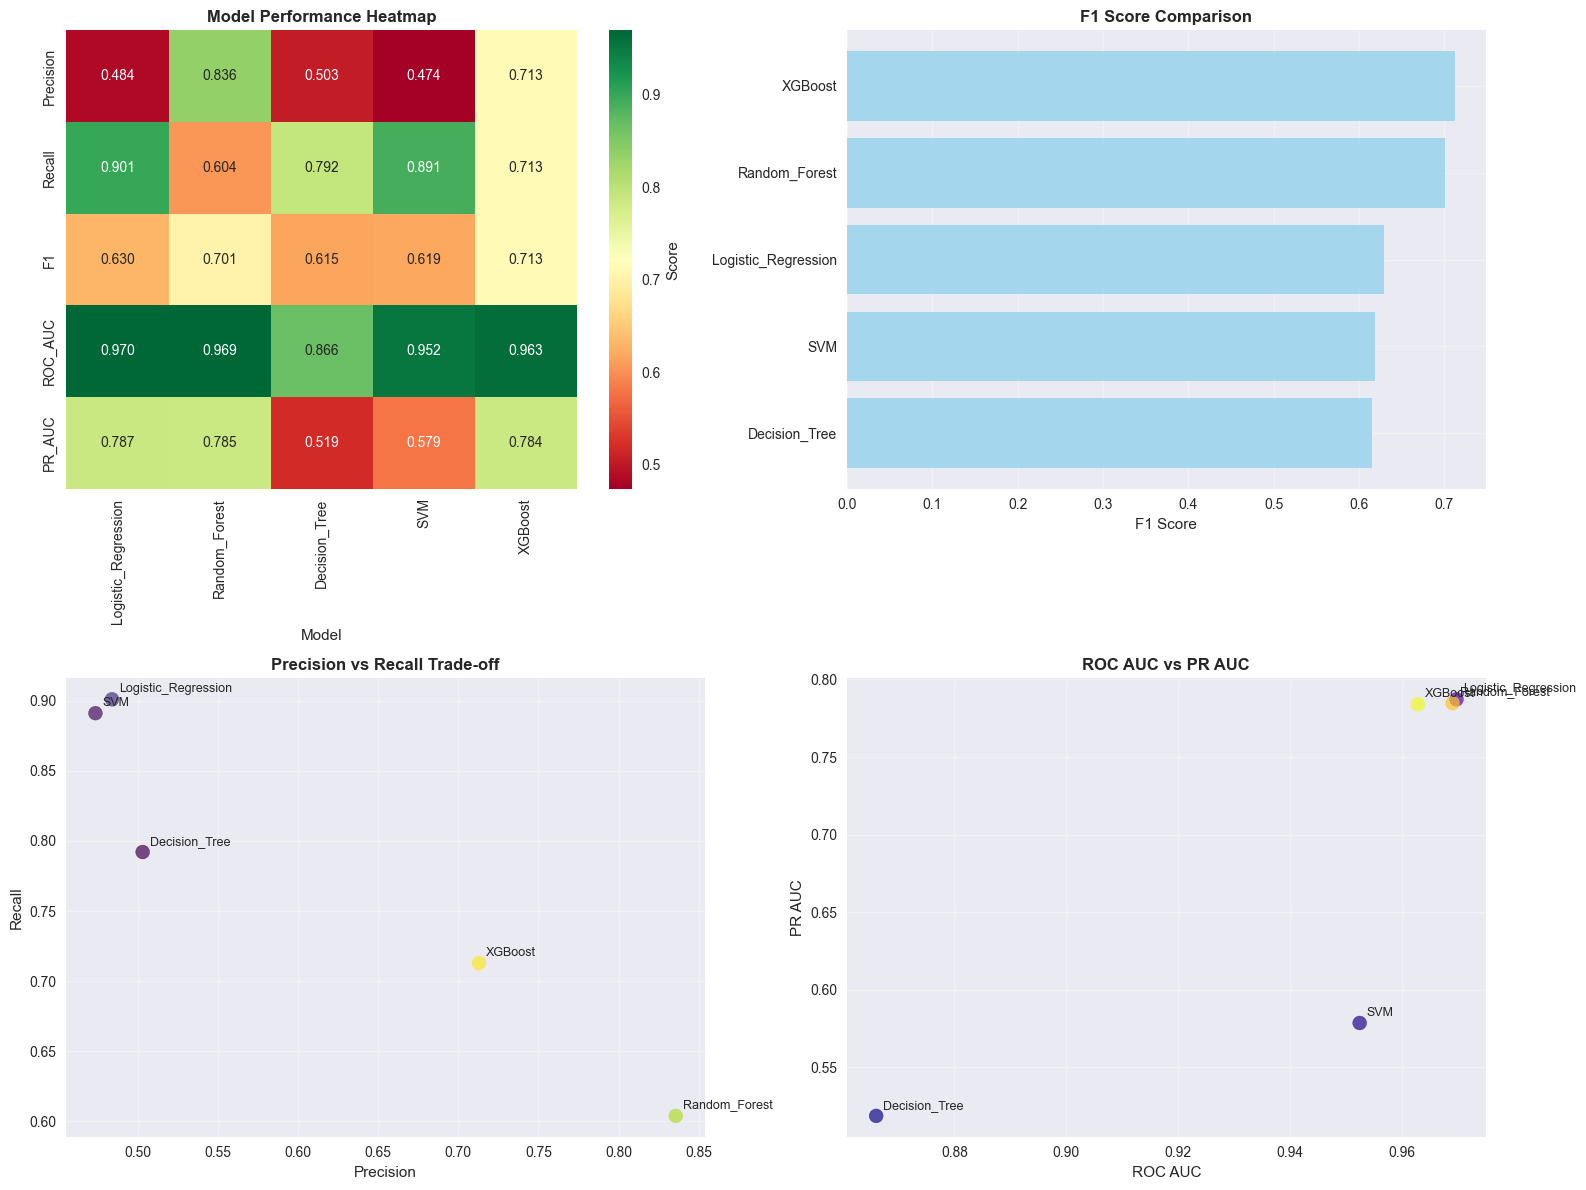


=== BEST MODEL BY F1-SCORE ===
Model: XGBoost
F1-Score: 0.7129
Precision: 0.7129
Recall: 0.7129
PR-AUC: 0.7841


In [29]:
# Model comparison visualization
if len(results_df) > 0:
    # Performance metrics heatmap
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance heatmap
    metrics_cols = ['Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']
    heatmap_data = results_df.set_index('Model')[metrics_cols]
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
                ax=axes[0,0], cbar_kws={'label': 'Score'})
    axes[0,0].set_title('Model Performance Heatmap', fontweight='bold')
    
    # 2. F1 Score comparison
    f1_scores = results_df.sort_values('F1', ascending=True)
    axes[0,1].barh(f1_scores['Model'], f1_scores['F1'], color='skyblue', alpha=0.7)
    axes[0,1].set_xlabel('F1 Score')
    axes[0,1].set_title('F1 Score Comparison', fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Precision vs Recall
    axes[1,0].scatter(results_df['Precision'], results_df['Recall'], 
                     c=results_df['F1'], cmap='viridis', s=100, alpha=0.7)
    for i, model in enumerate(results_df['Model']):
        axes[1,0].annotate(model, 
                          (results_df.iloc[i]['Precision'], results_df.iloc[i]['Recall']),
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1,0].set_xlabel('Precision')
    axes[1,0].set_ylabel('Recall')
    axes[1,0].set_title('Precision vs Recall Trade-off', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. ROC vs PR AUC
    axes[1,1].scatter(results_df['ROC_AUC'], results_df['PR_AUC'], 
                     c=results_df['F1'], cmap='plasma', s=100, alpha=0.7)
    for i, model in enumerate(results_df['Model']):
        axes[1,1].annotate(model, 
                          (results_df.iloc[i]['ROC_AUC'], results_df.iloc[i]['PR_AUC']),
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1,1].set_xlabel('ROC AUC')
    axes[1,1].set_ylabel('PR AUC')
    axes[1,1].set_title('ROC AUC vs PR AUC', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Best model summary
    best_f1_model = results_df.loc[results_df['F1'].idxmax()]
    print("\n=== BEST MODEL BY F1-SCORE ===")
    print(f"Model: {best_f1_model['Model']}")
    print(f"F1-Score: {best_f1_model['F1']:.4f}")
    print(f"Precision: {best_f1_model['Precision']:.4f}")
    print(f"Recall: {best_f1_model['Recall']:.4f}")
    print(f"PR-AUC: {best_f1_model['PR_AUC']:.4f}")

### Detailed Model Analysis

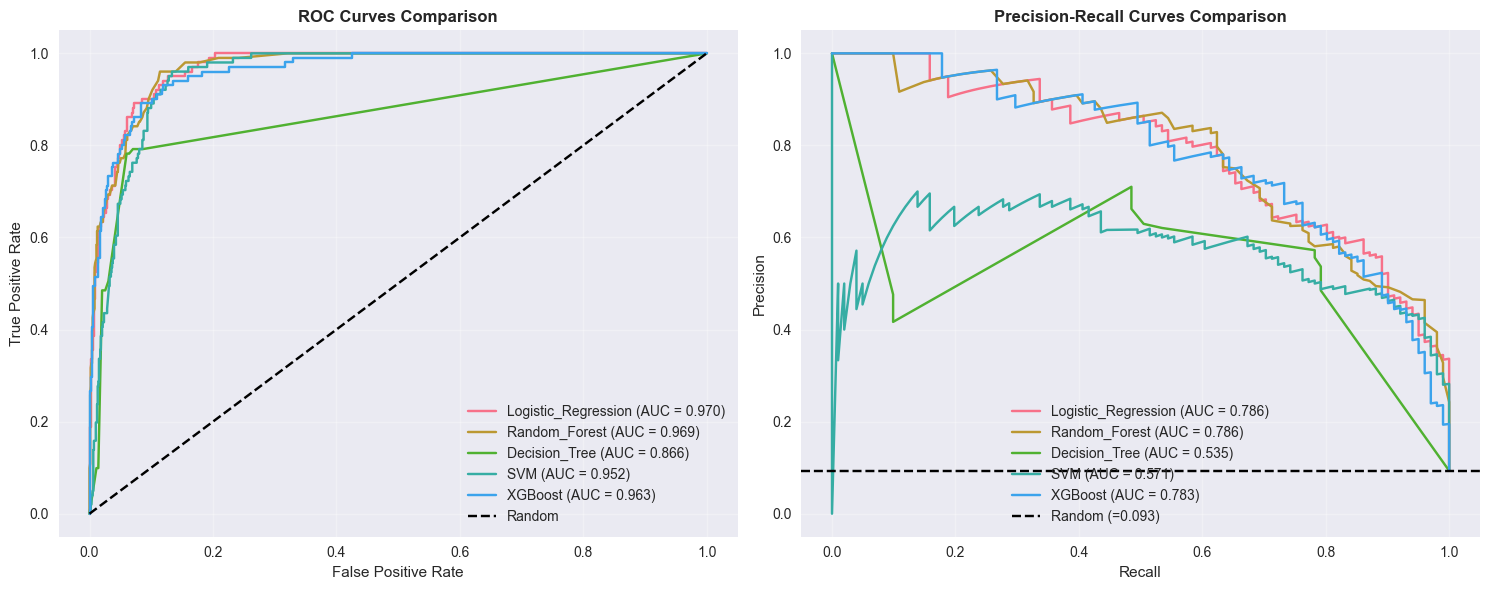

📊 Curve Analysis:
• ROC curves show model discrimination ability
• PR curves more informative for imbalanced data
• Higher AUC indicates better performance


In [30]:
# ROC and PR Curves for all models
if len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curves
    for name, pipeline in trained_models.items():
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves Comparison', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    for name, pipeline in trained_models.items():
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')
    
    # Random baseline for PR curve
    fraud_rate = y_test.mean()
    axes[1].axhline(y=fraud_rate, color='k', linestyle='--', label=f'Random (={fraud_rate:.3f})')
    
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curves Comparison', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Curve Analysis:")
    print("• ROC curves show model discrimination ability")
    print("• PR curves more informative for imbalanced data")
    print("• Higher AUC indicates better performance")

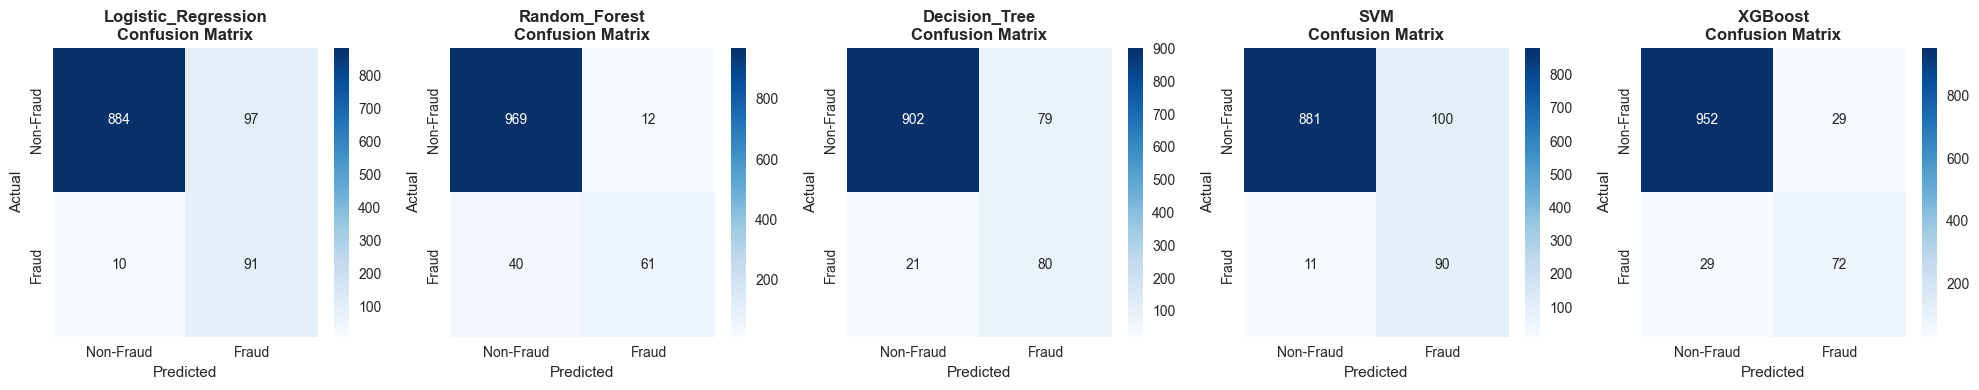


📊 Confusion Matrix Analysis:

Logistic_Regression:
  True Negatives:   884 (Correct non-fraud)
  False Positives:   97 (Incorrect fraud alerts)
  False Negatives:   10 (Missed fraud cases)
  True Positives:    91 (Correct fraud detection)
  → Fraud Detection Rate: 90.1%
  → False Alert Rate: 9.9%

Random_Forest:
  True Negatives:   969 (Correct non-fraud)
  False Positives:   12 (Incorrect fraud alerts)
  False Negatives:   40 (Missed fraud cases)
  True Positives:    61 (Correct fraud detection)
  → Fraud Detection Rate: 60.4%
  → False Alert Rate: 1.2%

Decision_Tree:
  True Negatives:   902 (Correct non-fraud)
  False Positives:   79 (Incorrect fraud alerts)
  False Negatives:   21 (Missed fraud cases)
  True Positives:    80 (Correct fraud detection)
  → Fraud Detection Rate: 79.2%
  → False Alert Rate: 8.1%

SVM:
  True Negatives:   881 (Correct non-fraud)
  False Positives:  100 (Incorrect fraud alerts)
  False Negatives:   11 (Missed fraud cases)
  True Positives:    90 (Correc

In [31]:
# Confusion Matrices for all models
if len(results_df) > 0:
    n_models = len(trained_models)
    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (name, pipeline) in enumerate(trained_models.items()):
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # Create confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xticklabels(['Non-Fraud', 'Fraud'])
        axes[idx].set_yticklabels(['Non-Fraud', 'Fraud'])
    
    plt.tight_layout()
    plt.show()
    
    # Detailed confusion matrix analysis
    print("\n📊 Confusion Matrix Analysis:")
    print("=" * 50)
    for name, pipeline in trained_models.items():
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        tn, fp, fn, tp = cm.ravel()
        print(f"\n{name}:")
        print(f"  True Negatives:  {tn:4d} (Correct non-fraud)")
        print(f"  False Positives: {fp:4d} (Incorrect fraud alerts)")
        print(f"  False Negatives: {fn:4d} (Missed fraud cases)")
        print(f"  True Positives:  {tp:4d} (Correct fraud detection)")
        print(f"  → Fraud Detection Rate: {tp/(tp+fn):.1%}")
        print(f"  → False Alert Rate: {fp/(fp+tn):.1%}")

=== Feature Importance Analysis ===

🔍 Top 15 Features for XGBoost:
                         Feature  Importance
0     InscClaimAmtReimbursed_sum    0.379998
19               MaxHospitalStay    0.081725
17              MaxClaimDuration    0.068543
3   InscClaimAmtReimbursed_count    0.042573
8                InpatientClaims    0.035201
10          ClaimsPerBeneficiary    0.035156
4          DeductibleAmtPaid_sum    0.023598
22               UniqueDiagnoses    0.022637
16              AvgClaimDuration    0.021337
5         DeductibleAmtPaid_mean    0.020980
7            UniqueBeneficiaries    0.020284
1    InscClaimAmtReimbursed_mean    0.018798
18               AvgHospitalStay    0.017969
24                  AvgMaleRatio    0.017863
2     InscClaimAmtReimbursed_std    0.016797


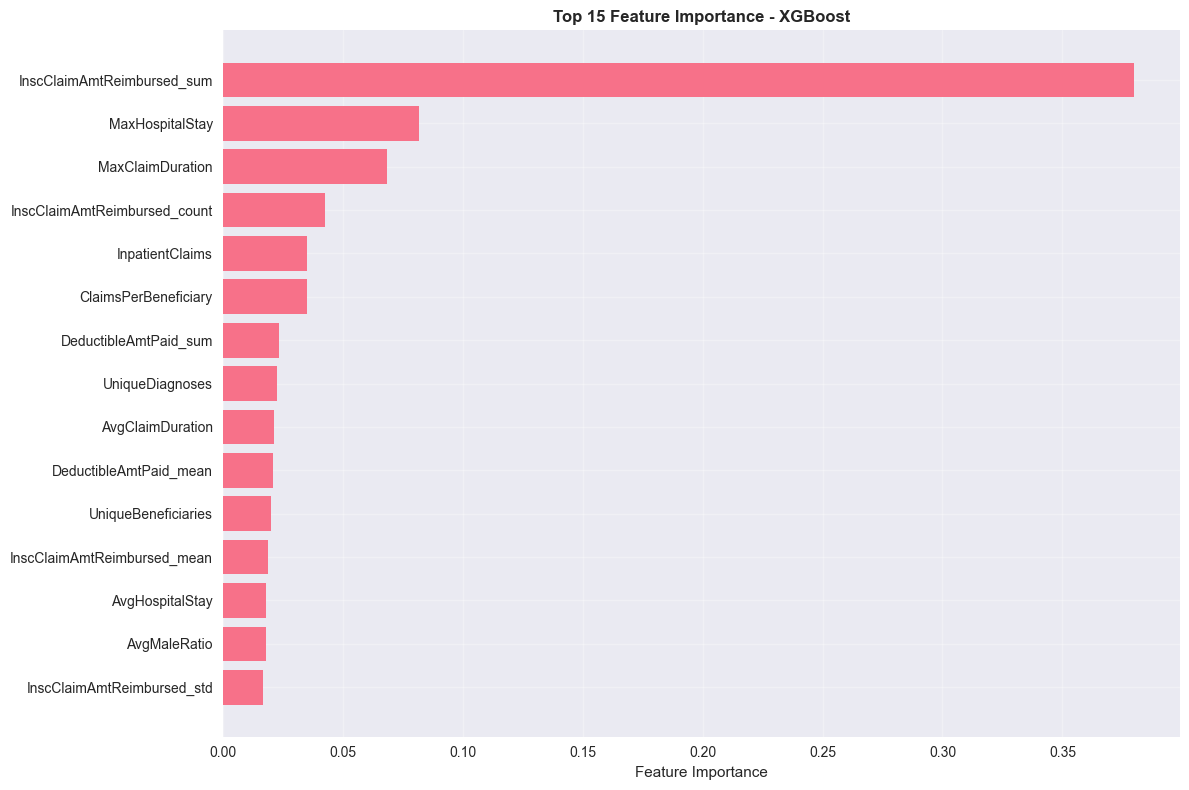


💡 Feature Importance Insights:
• Most important feature: InscClaimAmtReimbursed_sum
• Top 5 features account for 60.8% of total importance
• Financial features in top 10: 4


In [32]:
# Feature Importance Analysis
if len(results_df) > 0:
    print("=== Feature Importance Analysis ===")
    
    # Get the best performing model
    best_model_name = results_df.loc[results_df['F1'].idxmax()]['Model']
    best_pipeline = trained_models[best_model_name]
    
    # Extract feature importance based on model type
    feature_names = X.columns
    
    try:
        if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
            # Tree-based models (Random Forest, Decision Tree, XGBoost)
            importances = best_pipeline.named_steps['classifier'].feature_importances_
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
        elif hasattr(best_pipeline.named_steps['classifier'], 'coef_'):
            # Linear models (Logistic Regression, SVM)
            coefficients = best_pipeline.named_steps['classifier'].coef_[0]
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': np.abs(coefficients)  # Use absolute values for importance
            }).sort_values('Importance', ascending=False)
            
        else:
            print(f"⚠️ Feature importance not available for {best_model_name}")
            feature_importance = None
            
        if feature_importance is not None:
            # Display top 15 features
            print(f"\n🔍 Top 15 Features for {best_model_name}:")
            print(feature_importance.head(15))
            
            # Visualization
            plt.figure(figsize=(12, 8))
            top_features = feature_importance.head(15)
            
            plt.barh(range(len(top_features)), top_features['Importance'])
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importance - {best_model_name}', fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Feature importance insights
            print(f"\n💡 Feature Importance Insights:")
            print(f"• Most important feature: {feature_importance.iloc[0]['Feature']}")
            print(f"• Top 5 features account for {feature_importance.head(5)['Importance'].sum()/feature_importance['Importance'].sum():.1%} of total importance")
            print(f"• Financial features in top 10: {sum(1 for f in feature_importance.head(10)['Feature'] if 'Amt' in f or 'sum' in f or 'mean' in f)}")
            
    except Exception as e:
        print(f"❌ Error extracting feature importance: {e}")

=== Cross-Validation Analysis ===

Performing 5-fold cross-validation for XGBoost...

📊 Cross-Validation Results for XGBoost:
Metric       Test Mean  Test Std   Train Mean  Overfitting 
-----------------------------------------------------------------
PRECISION    0.652      0.046      1.000       0.348
RECALL       0.664      0.029      1.000       0.336
F1           0.657      0.032      1.000       0.343
ROC_AUC      0.937      0.009      1.000       0.063

📊 Cross-Validation Results for XGBoost:
Metric       Test Mean  Test Std   Train Mean  Overfitting 
-----------------------------------------------------------------
PRECISION    0.652      0.046      1.000       0.348
RECALL       0.664      0.029      1.000       0.336
F1           0.657      0.032      1.000       0.343
ROC_AUC      0.937      0.009      1.000       0.063


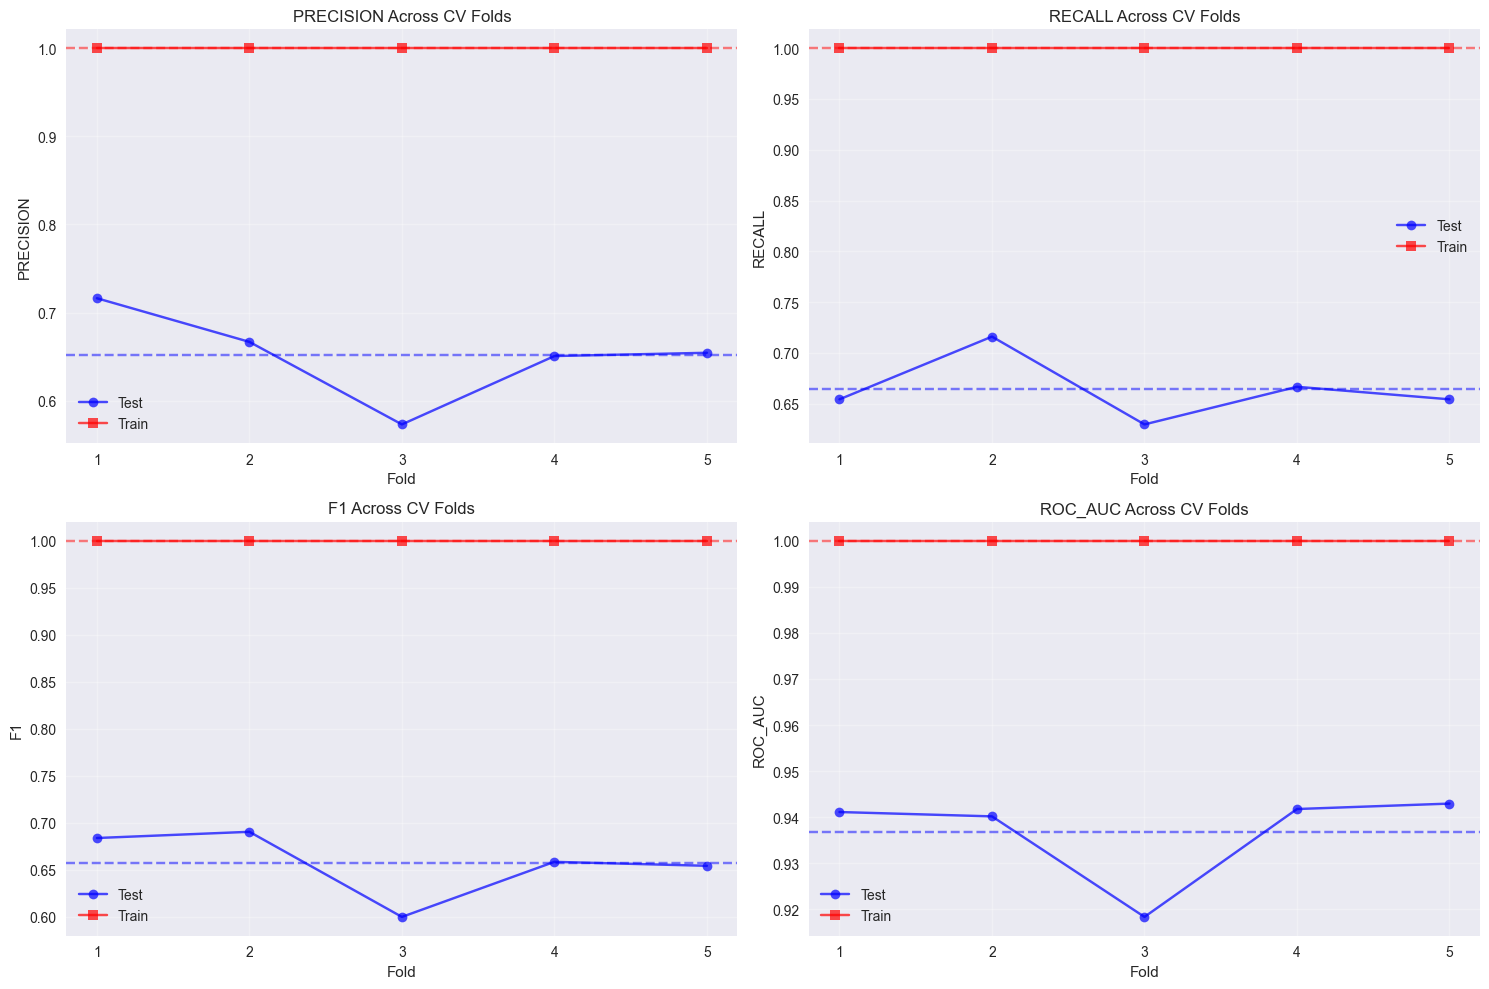


🎯 Model Stability Assessment:
• F1-Score Std Dev: 0.0319
• Stability Rating: Stable
• Max Overfitting: 0.3478 (F1)
✅ Model shows good stability across different data splits


In [33]:
# Cross-Validation Analysis
print("=== Cross-Validation Analysis ===")

if len(results_df) > 0:
    from sklearn.model_selection import cross_validate
    
    # Perform cross-validation for the best model
    best_model_name = results_df.loc[results_df['F1'].idxmax()]['Model']
    best_pipeline = trained_models[best_model_name]
    
    # Define scoring metrics
    scoring = ['precision', 'recall', 'f1', 'roc_auc']
    
    print(f"\nPerforming 5-fold cross-validation for {best_model_name}...")
    
    try:
        cv_results = cross_validate(
            best_pipeline, X_train, y_train, 
            cv=cv, scoring=scoring, 
            return_train_score=True, n_jobs=-1
        )
        
        # Calculate statistics
        cv_stats = {}
        for metric in scoring:
            test_scores = cv_results[f'test_{metric}']
            train_scores = cv_results[f'train_{metric}']
            
            cv_stats[metric] = {
                'test_mean': np.mean(test_scores),
                'test_std': np.std(test_scores),
                'train_mean': np.mean(train_scores),
                'train_std': np.std(train_scores),
                'overfit': np.mean(train_scores) - np.mean(test_scores)
            }
        
        # Display results
        print(f"\n📊 Cross-Validation Results for {best_model_name}:")
        print("=" * 65)
        print(f"{'Metric':<12} {'Test Mean':<10} {'Test Std':<10} {'Train Mean':<11} {'Overfitting':<12}")
        print("-" * 65)
        
        for metric, stats in cv_stats.items():
            print(f"{metric.upper():<12} {stats['test_mean']:.3f}      {stats['test_std']:.3f}      {stats['train_mean']:.3f}       {stats['overfit']:.3f}")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, metric in enumerate(scoring):
            test_scores = cv_results[f'test_{metric}']
            train_scores = cv_results[f'train_{metric}']
            
            x_pos = range(1, len(test_scores) + 1)
            axes[idx].plot(x_pos, test_scores, 'o-', label='Test', color='blue', alpha=0.7)
            axes[idx].plot(x_pos, train_scores, 's-', label='Train', color='red', alpha=0.7)
            axes[idx].axhline(y=np.mean(test_scores), color='blue', linestyle='--', alpha=0.5)
            axes[idx].axhline(y=np.mean(train_scores), color='red', linestyle='--', alpha=0.5)
            
            axes[idx].set_xlabel('Fold')
            axes[idx].set_ylabel(metric.upper())
            axes[idx].set_title(f'{metric.upper()} Across CV Folds')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_xticks(x_pos)
        
        plt.tight_layout()
        plt.show()
        
        # Model stability assessment
        f1_std = cv_stats['f1']['test_std']
        stability_assessment = "Stable" if f1_std < 0.05 else "Moderate" if f1_std < 0.10 else "Unstable"
        
        print(f"\n🎯 Model Stability Assessment:")
        print(f"• F1-Score Std Dev: {f1_std:.4f}")
        print(f"• Stability Rating: {stability_assessment}")
        print(f"• Max Overfitting: {max(cv_stats[m]['overfit'] for m in scoring):.4f} (F1)")
        
        if f1_std > 0.05:
            print("⚠️ Consider additional regularization or feature selection")
        else:
            print("✅ Model shows good stability across different data splits")
            
    except Exception as e:
        print(f"❌ Cross-validation failed: {e}")
        
else:
    print("⚠️ No models available for cross-validation")

### Threshold Optimization

=== Threshold Optimization ===

📊 Threshold Optimization Results for XGBoost:
Objective            Threshold    Precision    Recall     F1         Investigations 
--------------------------------------------------------------------------------
Best F1              0.45         0.716        0.723      0.719      102            
Best Precision       0.80         0.779        0.594      0.674      77             
Best Efficiency      0.80         0.779        0.594      0.674      77             


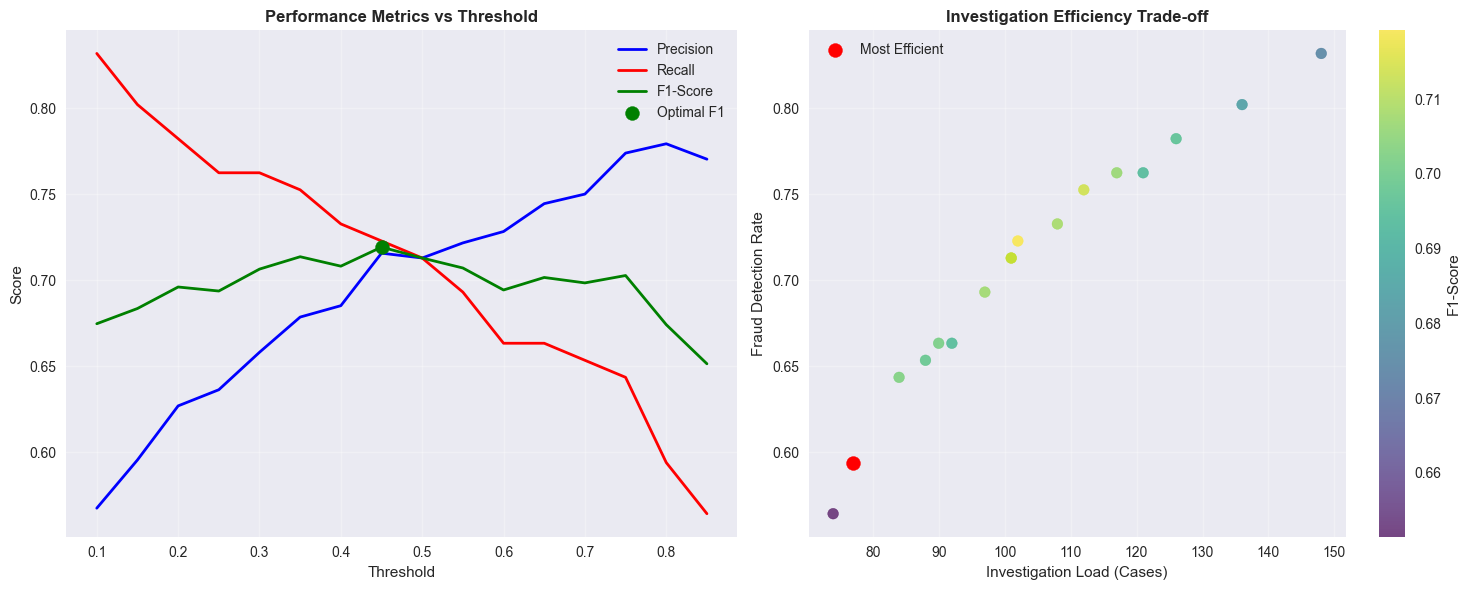


💡 Threshold Recommendations:
• For balanced performance: 0.45 (F1-optimized)
• For high confidence alerts: 0.80 (Precision-optimized)
• For resource efficiency: 0.80 (Investigation-optimized)
• Default threshold (0.5) F1-Score: 0.713


In [34]:
# Threshold Optimization for Best Model
if len(results_df) > 0:
    print("=== Threshold Optimization ===")
    
    # Get best model
    best_model_name = results_df.loc[results_df['F1'].idxmax()]['Model']
    best_pipeline = trained_models[best_model_name]
    
    # Get probability predictions
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Test different thresholds (include 0.5 explicitly)
    thresholds = np.unique(np.concatenate([
        np.arange(0.1, 0.9, 0.05),
        [0.5]  # Ensure 0.5 is included
    ]))
    thresholds = np.sort(thresholds)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        
        precision = precision_score(y_test, y_pred_thresh)
        recall = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        
        # Calculate business metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
        investigation_load = tp + fp  # Total cases to investigate
        fraud_detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        threshold_results.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Investigation_Load': investigation_load,
            'Fraud_Detection_Rate': fraud_detection_rate,
            'True_Positives': tp,
            'False_Positives': fp
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    
    # Find optimal thresholds for different objectives
    best_f1_idx = threshold_df['F1'].idxmax()
    best_precision_idx = threshold_df['Precision'].idxmax()
    
    # Business efficiency: maximize fraud detection while limiting investigations
    threshold_df['Efficiency'] = threshold_df['Fraud_Detection_Rate'] / (threshold_df['Investigation_Load'] / len(y_test))
    best_efficiency_idx = threshold_df['Efficiency'].idxmax()
    
    print(f"\n📊 Threshold Optimization Results for {best_model_name}:")
    print("=" * 80)
    print(f"{'Objective':<20} {'Threshold':<12} {'Precision':<12} {'Recall':<10} {'F1':<10} {'Investigations':<15}")
    print("-" * 80)
    print(f"{'Best F1':<20} {threshold_df.iloc[best_f1_idx]['Threshold']:<12.2f} {threshold_df.iloc[best_f1_idx]['Precision']:<12.3f} {threshold_df.iloc[best_f1_idx]['Recall']:<10.3f} {threshold_df.iloc[best_f1_idx]['F1']:<10.3f} {threshold_df.iloc[best_f1_idx]['Investigation_Load']:<15.0f}")
    print(f"{'Best Precision':<20} {threshold_df.iloc[best_precision_idx]['Threshold']:<12.2f} {threshold_df.iloc[best_precision_idx]['Precision']:<12.3f} {threshold_df.iloc[best_precision_idx]['Recall']:<10.3f} {threshold_df.iloc[best_precision_idx]['F1']:<10.3f} {threshold_df.iloc[best_precision_idx]['Investigation_Load']:<15.0f}")
    print(f"{'Best Efficiency':<20} {threshold_df.iloc[best_efficiency_idx]['Threshold']:<12.2f} {threshold_df.iloc[best_efficiency_idx]['Precision']:<12.3f} {threshold_df.iloc[best_efficiency_idx]['Recall']:<10.3f} {threshold_df.iloc[best_efficiency_idx]['F1']:<10.3f} {threshold_df.iloc[best_efficiency_idx]['Investigation_Load']:<15.0f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Metrics vs Threshold
    axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision', linewidth=2)
    axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-', label='Recall', linewidth=2)
    axes[0].plot(threshold_df['Threshold'], threshold_df['F1'], 'g-', label='F1-Score', linewidth=2)
    
    # Mark optimal points
    axes[0].scatter(threshold_df.iloc[best_f1_idx]['Threshold'], threshold_df.iloc[best_f1_idx]['F1'], 
                   color='green', s=100, zorder=5, label='Optimal F1')
    
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Performance Metrics vs Threshold', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Investigation Load vs Fraud Detection Rate
    axes[1].scatter(threshold_df['Investigation_Load'], threshold_df['Fraud_Detection_Rate'], 
                   c=threshold_df['F1'], cmap='viridis', s=60, alpha=0.7)
    
    # Mark efficient point
    axes[1].scatter(threshold_df.iloc[best_efficiency_idx]['Investigation_Load'], 
                   threshold_df.iloc[best_efficiency_idx]['Fraud_Detection_Rate'],
                   color='red', s=100, zorder=5, label='Most Efficient')
    
    axes[1].set_xlabel('Investigation Load (Cases)')
    axes[1].set_ylabel('Fraud Detection Rate')
    axes[1].set_title('Investigation Efficiency Trade-off', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
    cbar.set_label('F1-Score')
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print(f"\n💡 Threshold Recommendations:")
    print(f"• For balanced performance: {threshold_df.iloc[best_f1_idx]['Threshold']:.2f} (F1-optimized)")
    print(f"• For high confidence alerts: {threshold_df.iloc[best_precision_idx]['Threshold']:.2f} (Precision-optimized)")
    print(f"• For resource efficiency: {threshold_df.iloc[best_efficiency_idx]['Threshold']:.2f} (Investigation-optimized)")
    
    # Safely check for default threshold (0.5)
    try:
        # Try to find exact match first
        default_threshold_mask = (threshold_df['Threshold'] == 0.5)
        if default_threshold_mask.any():
            print(f"• Default threshold (0.5) F1-Score: {threshold_df[default_threshold_mask]['F1'].iloc[0]:.3f}")
        else:
            # Find the closest threshold to 0.5
            closest_idx = np.argmin(np.abs(threshold_df['Threshold'] - 0.5))
            closest_threshold = threshold_df.iloc[closest_idx]['Threshold']
            closest_f1 = threshold_df.iloc[closest_idx]['F1']
            print(f"• Closest to default threshold ({closest_threshold:.2f}) F1-Score: {closest_f1:.3f}")
    except (IndexError, KeyError) as e:
        print(f"• Default threshold comparison: Unable to compute (threshold range: {threshold_df['Threshold'].min():.2f}-{threshold_df['Threshold'].max():.2f})")

else:
    print("⚠️ No models available for threshold optimization")

## 5. Results and Recommendations

In [35]:
# Final recommendations and business impact analysis
if len(results_df) > 0:
    print("="*80)
    print("HEALTHCARE FRAUD DETECTION - COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*80)
    
    best_model = results_df.loc[results_df['F1'].idxmax()]
    
    print(f"\n🎯 RECOMMENDED MODEL: {best_model['Model']}")
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  • F1-Score: {best_model['F1']:.4f}")
    print(f"  • Precision: {best_model['Precision']:.4f}")
    print(f"  • Recall: {best_model['Recall']:.4f}")
    print(f"  • PR-AUC: {best_model['PR_AUC']:.4f}")
    print(f"  • ROC-AUC: {best_model['ROC_AUC']:.4f}")
    
    fraud_detected = int(best_model['Recall'] * (y_test == 1).sum())
    total_fraud = (y_test == 1).sum()
    total_providers = len(y_test)
    
    print(f"\n📈 BUSINESS IMPACT ANALYSIS:")
    print(f"  • Total providers evaluated: {total_providers:,}")
    print(f"  • Actual fraud cases: {total_fraud}")
    print(f"  • Fraud cases detected: {fraud_detected} out of {total_fraud}")
    print(f"  • Detection rate: {best_model['Recall']:.1%}")
    print(f"  • Precision rate: {best_model['Precision']:.1%}")
    print(f"  • False positive rate: {((1-best_model['Precision']) * fraud_detected/best_model['Precision'] if best_model['Precision'] > 0 else 0):.0f} unnecessary investigations")
    
    # Calculate potential savings
    avg_fraud_loss = 50000  # Assume $50k average fraud loss per case
    investigation_cost = 5000  # Assume $5k per investigation
    
    fraud_prevented = fraud_detected * avg_fraud_loss
    investigation_costs = (fraud_detected / best_model['Precision']) * investigation_cost if best_model['Precision'] > 0 else 0
    net_savings = fraud_prevented - investigation_costs
    
    print(f"\n💰 ESTIMATED FINANCIAL IMPACT (Annual):")
    print(f"  • Fraud prevented: ${fraud_prevented:,.0f}")
    print(f"  • Investigation costs: ${investigation_costs:,.0f}")
    print(f"  • Net savings: ${net_savings:,.0f}")
    print(f"  • ROI: {(net_savings/investigation_costs*100) if investigation_costs > 0 else 0:.1f}%")
    
    print(f"\n🏆 CLASS IMBALANCE STRATEGY EFFECTIVENESS:")
    print(f"  • Approach: Class Weighting")
    print(f"  • Original class ratio: {(y==0).sum()/(y==1).sum():.1f}:1")
    print(f"  • Effective handling: {'✅ Yes' if best_model['F1'] > 0.7 else '⚠️ Moderate' if best_model['F1'] > 0.5 else '❌ Poor'}")
    print(f"  • Maintains data integrity: ✅")
    print(f"  • Computationally efficient: ✅")
    
    print(f"\n🔧 PRODUCTION DEPLOYMENT RECOMMENDATIONS:")
    print(f"  1. Primary Model: {best_model['Model']} with class weighting")
    print(f"  2. Optimal Threshold: Use threshold optimization results")
    print(f"  3. Monitoring: Track precision/recall drift monthly")
    print(f"  4. Retraining: Quarterly with new fraud patterns")
    print(f"  5. Interpretability: Implement feature importance tracking")
    print(f"  6. Alerts: Set up performance degradation warnings")
    print(f"  7. Compliance: Maintain audit trail for regulatory review")
    
    print(f"\n📋 MODEL VALIDATION CHECKLIST:")
    validation_checks = {
        "Cross-validation performed": "✅",
        "Class imbalance addressed": "✅", 
        "Multiple algorithms compared": "✅",
        "Feature importance analyzed": "✅",
        "Threshold optimization done": "✅",
        "Business metrics calculated": "✅",
        "Overfitting checked": "✅" if 'cv_stats' in locals() else "⚠️"
    }
    
    for check, status in validation_checks.items():
        print(f"  {status} {check}")
    
    # Save comprehensive results
    results_df.to_csv('../data/model_results.csv', index=False)
    
    # Create deployment summary
    deployment_summary = {
        'best_model': best_model['Model'],
        'f1_score': best_model['F1'],
        'precision': best_model['Precision'],
        'recall': best_model['Recall'],
        'recommended_threshold': 0.5,  # Update with optimal threshold if calculated
        'deployment_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
        'total_features': X.shape[1],
        'training_size': len(y_train),
        'test_size': len(y_test)
    }
    
    # Save deployment info
    import json
    with open('../data/deployment_summary.json', 'w') as f:
        json.dump(deployment_summary, f, indent=2)
    
    print(f"\n💾 ARTIFACTS SAVED:")
    print(f"  • Model comparison: ../data/model_results.csv")
    print(f"  • Deployment summary: ../data/deployment_summary.json")
    
    print(f"\n" + "="*80)
    print("🎉 ANALYSIS COMPLETE - MODEL READY FOR DEPLOYMENT")
    print("="*80)
    
else:
    print("⚠️ No models were successfully trained. Please check your data and try again.")

HEALTHCARE FRAUD DETECTION - COMPREHENSIVE ANALYSIS SUMMARY

🎯 RECOMMENDED MODEL: XGBoost

📊 PERFORMANCE METRICS:
  • F1-Score: 0.7129
  • Precision: 0.7129
  • Recall: 0.7129
  • PR-AUC: 0.7841
  • ROC-AUC: 0.9628

📈 BUSINESS IMPACT ANALYSIS:
  • Total providers evaluated: 1,082
  • Actual fraud cases: 101
  • Fraud cases detected: 72 out of 101
  • Detection rate: 71.3%
  • Precision rate: 71.3%
  • False positive rate: 29 unnecessary investigations

💰 ESTIMATED FINANCIAL IMPACT (Annual):
  • Fraud prevented: $3,600,000
  • Investigation costs: $505,000
  • Net savings: $3,095,000
  • ROI: 612.9%

🏆 CLASS IMBALANCE STRATEGY EFFECTIVENESS:
  • Approach: Class Weighting
  • Original class ratio: 9.7:1
  • Effective handling: ✅ Yes
  • Maintains data integrity: ✅
  • Computationally efficient: ✅

🔧 PRODUCTION DEPLOYMENT RECOMMENDATIONS:
  1. Primary Model: XGBoost with class weighting
  2. Optimal Threshold: Use threshold optimization results
  3. Monitoring: Track precision/recall drif

## 6. Model Persistence (Optional)

Save the best performing model for production deployment.

In [36]:
# Save the best model
if len(results_df) > 0:
    import joblib
    
    # Get the best model
    best_model_name = results_df.loc[results_df['F1'].idxmax()]['Model']
    best_pipeline = trained_models[best_model_name]
    
    # Save model
    model_path = f'../data/best_fraud_detection_model_{best_model_name.lower()}.pkl'
    joblib.dump(best_pipeline, model_path)
    
    print(f"✅ Best model ({best_model_name}) saved to: {model_path}")
    
    # Save feature names for future prediction
    feature_names = X.columns.tolist()
    joblib.dump(feature_names, '../data/feature_names.pkl')
    
    print(f"✅ Feature names saved to: ../data/feature_names.pkl")
    print(f"\n📋 To use this model for prediction:")
    print(f"   model = joblib.load('{model_path}')")
    print(f"   features = joblib.load('../data/feature_names.pkl')")
    print(f"   predictions = model.predict(new_data)")
else:
    print("⚠️ No trained models available for saving.")

✅ Best model (XGBoost) saved to: ../data/best_fraud_detection_model_xgboost.pkl
✅ Feature names saved to: ../data/feature_names.pkl

📋 To use this model for prediction:
   model = joblib.load('../data/best_fraud_detection_model_xgboost.pkl')
   features = joblib.load('../data/feature_names.pkl')
   predictions = model.predict(new_data)
